In [89]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

#linear model with weight and bias: 0-dim tensors
def model(t_u, w, b):
    return w * t_u + b

#mean square loss
def loss_fn(t_p, t_c):
    sq_def = (t_p - t_c)**2
    return sq_def.mean()

#init params
w = torch.ones(())
b = torch.zeros(())

#gradient descent
'''
delta = 0.1
learning_rate = 1e-2

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / 2.0 * delta
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / 2.0 * delta

w -= learning_rate * loss_rate_of_change_w
b -= learning_rate * loss_rate_of_change_b
'''

'''
gradient of loss wrt parameters (weight and bias) = 
derivative of loss wrt weight, and derivative of loss wrt bias.

derivative of loss wrt weight (bias) =
derivative of loss wrt model * derivative of model wrt weight (bias)
'''

#derivate of loss wrt model (t_p)
def d_loss_fn_wrt_model(t_p, t_c):
    return 2 * (t_p - t_c) / t_p.size(0) #t_p.size(0) = 11, coming from mean() in loss_fn()

#derivate of model wrt weight
def d_model_wrt_w(t_u, w, b):
    return t_u

#derivate of model wrt bias
def d_model_wrt_b(t_u, w, b):
    return 1.0

# gradient of loss wrt weight and bias
def gradient_fn(t_u, t_c, t_p, w, b):
    dl_dw = d_loss_fn_wrt_model(t_p, t_c) * d_model_wrt_w(t_u, w, b)
    dl_db = d_loss_fn_wrt_model(t_p, t_c) * d_model_wrt_b(t_u, w, b)
    return torch.stack([dl_dw.sum(),dl_db.sum()])

def training_loop(n_epochs, learning_rate, params, t_c, t_u):
    for epoch in range(1, n_epochs + 1):
        w,b = params
        t_p = model(t_u, w, b)
        params -= learning_rate * gradient_fn(t_u, t_c, t_p, w, b)
        #print('epoch %d, loss %f' %(epoch, loss_fn(t_p, t_c).float()))
    return params

t_un = .1 * t_u #normalize samples
params = training_loop(n_epochs = 10000, 
              learning_rate = 1e-2, 
              params = torch.tensor([1.0, 0.0]), 
              t_c = t_c, 
              t_u = t_un)
params

tensor([  5.3676, -17.3042])

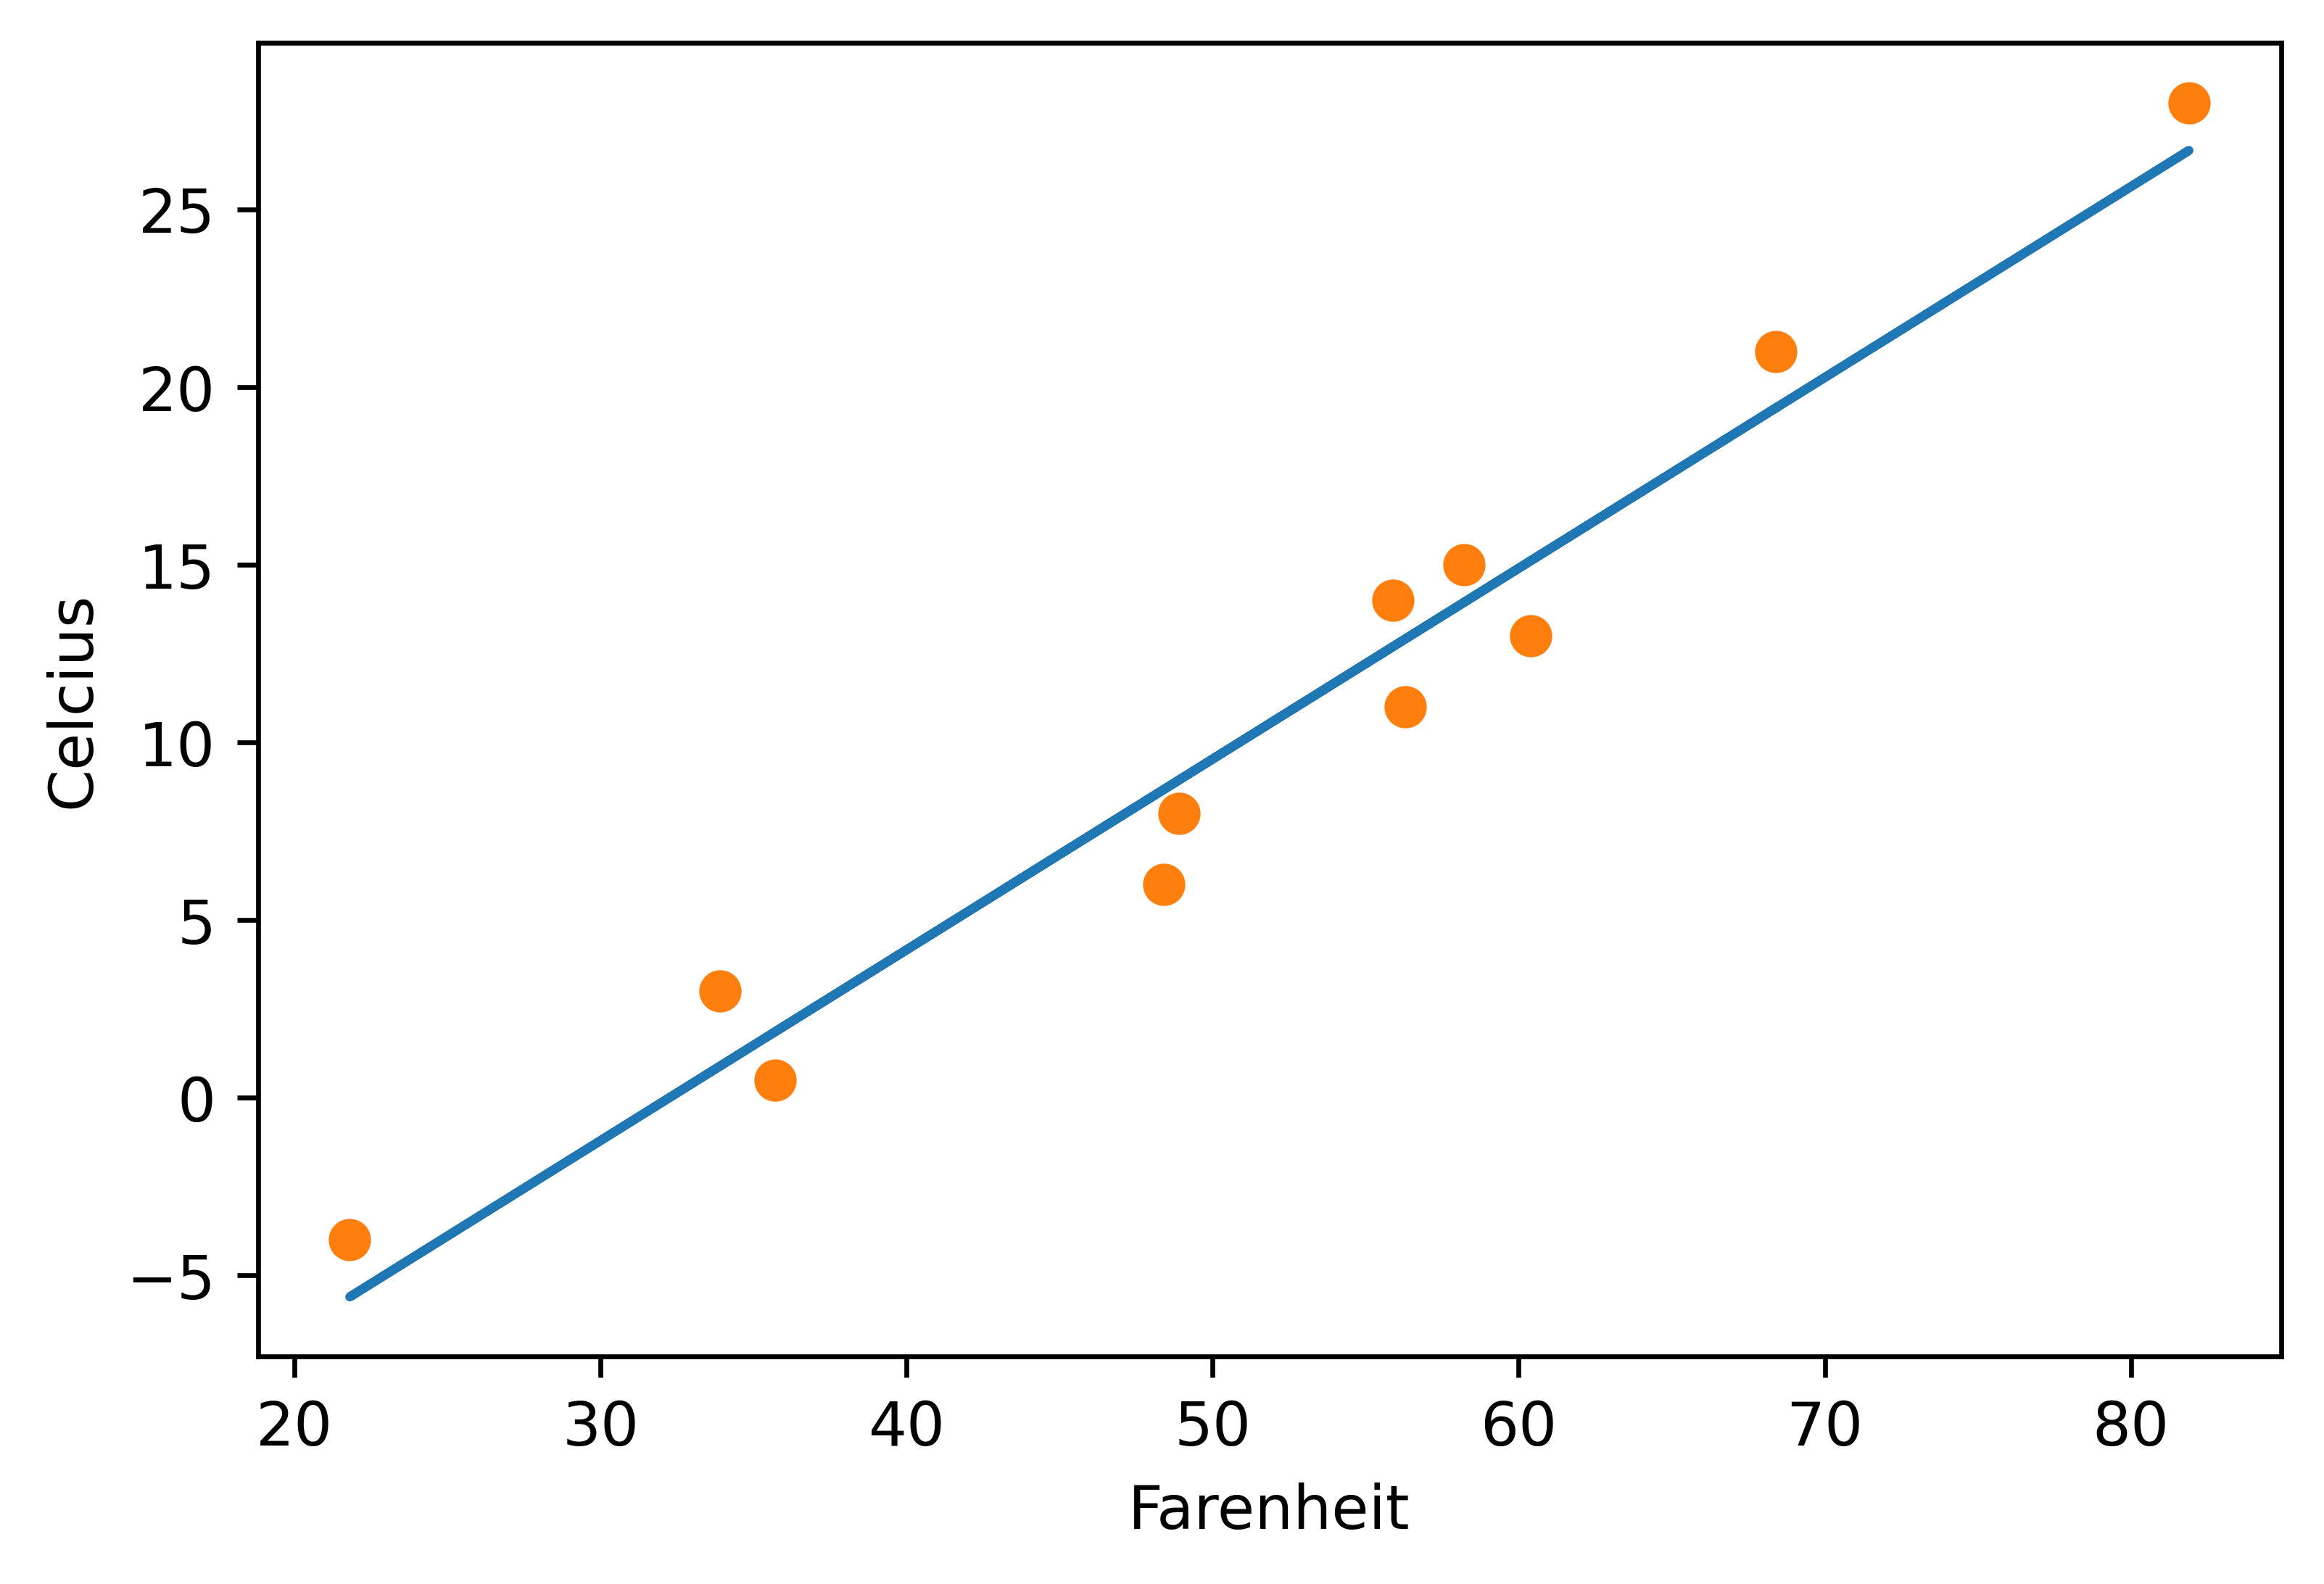

In [90]:
from matplotlib import pyplot as plt

t_p = model(t_un, *params) #*params unpacks it
fig = plt.figure(dpi=600)
plt.xlabel("Farenheit")
plt.ylabel("Celcius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')


In [112]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
params.grad is None #it is!

loss = loss_fn(model(t_u, *params), t_c)
loss.backward() #does backward propagation and computes gradient wrt tensor parameters whose requires_grade is on.
params.grad #derivative of loss wrt what we have in params: weight and bias
if params.grad is not None:
    params.grad.zero_()
params.grad

def training_loop_2 (n_epochs, learning_rate, params, t_c, t_u):
    for epoch in range(1 + n_epochs):
        if params.grad is not None:
            params.grad.zero_()
        loss = loss_fn(model(t_u,*params), t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad
        if epoch % 100000 == 0:
            print('epoch: %d, loss:%f' %(epoch, loss.float()))
    return params

training_loop_2(n_epochs = 1000000, 
                learning_rate = 1e-2, 
                params = torch.tensor([1.0, 0.0], requires_grad = True), 
                t_c = t_c, 
                t_u = t_un)

epoch: 0, loss:80.364342
epoch: 100000, loss:2.927645
epoch: 200000, loss:2.927645
epoch: 300000, loss:2.927645
epoch: 400000, loss:2.927645
epoch: 500000, loss:2.927645
epoch: 600000, loss:2.927645
epoch: 700000, loss:2.927645
epoch: 800000, loss:2.927645
epoch: 900000, loss:2.927645
epoch: 1000000, loss:2.927645


tensor([  5.3676, -17.3042], requires_grad=True)

In [123]:
import torch.optim as optim
dir(optim)

params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr = learning_rate) 
loss = loss_fn(model(t_u,*params), t_c)
optimizer.zero_grad() #zeros params
loss.backward()
optimizer.step() #updates params using SGD strategy
params

def training_loop_3(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1+n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model(t_u, *params), t_c)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('epoch: %d, loss: %f' %(epoch, loss.float()))
    return params

params = torch.tensor([1.0,0.0], requires_grad = True)

training_loop_3(n_epochs = 5000,
                optimizer = optim.SGD([params], lr = 1e-2),
                params = params,
                t_u = t_un,
                t_c = t_c
               )

epoch: 0, loss: 80.364342
epoch: 500, loss: 7.843369
epoch: 1000, loss: 3.825483
epoch: 1500, loss: 3.091630
epoch: 2000, loss: 2.957596
epoch: 2500, loss: 2.933116
epoch: 3000, loss: 2.928646
epoch: 3500, loss: 2.927829
epoch: 4000, loss: 2.927679
epoch: 4500, loss: 2.927652
epoch: 5000, loss: 2.927648


tensor([  5.3671, -17.3012], requires_grad=True)

In [142]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

random_indexes = torch.randperm(n_samples)
train_indexes = random_indexes[:-n_val]
val_indexes = random_indexes[-n_val:]

train_t_u = t_u[train_indexes]
train_t_c = t_c[train_indexes]
val_t_u = t_u[val_indexes]
val_t_c = t_c[val_indexes]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

def training_loop_4(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1 + n_epochs):
        train_loss = loss_fn(model(train_t_u, *params), train_t_c)
        val_loss = loss_fn(model(val_t_u, *params), val_t_c)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

params = torch.tensor([1.0, 0.0], requires_grad = True)

training_loop_4(n_epochs = 3000,
               optimizer = optim.SGD([params], lr = 1e-2),
               params = params,
               train_t_u = train_t_un,
               train_t_c = train_t_c,
               val_t_u = val_t_un,
               val_t_c = val_t_c)

Epoch 0, Training loss 89.6366, Validation loss 38.6392
Epoch 1, Training loss 44.9269, Validation loss 2.5454
Epoch 2, Training loss 37.1240, Validation loss 0.5562
Epoch 3, Training loss 35.6690, Validation loss 1.9668
Epoch 500, Training loss 6.6510, Validation loss 5.3585
Epoch 1000, Training loss 2.9628, Validation loss 6.1126
Epoch 1500, Training loss 2.4962, Validation loss 6.4036
Epoch 2000, Training loss 2.4372, Validation loss 6.5100
Epoch 2500, Training loss 2.4297, Validation loss 6.5482
Epoch 3000, Training loss 2.4288, Validation loss 6.5619


tensor([  5.4815, -17.4261], requires_grad=True)

Epoch 0, Training loss 652.1229, Validation loss 782.3155
Epoch 1, Training loss 389.8318, Validation loss 483.7689
Epoch 2, Training loss 235.6202, Validation loss 303.2241
Epoch 3, Training loss 144.9514, Validation loss 193.2276
Epoch 500, Training loss 11.8498, Validation loss 4.4188
Epoch 1000, Training loss 9.3159, Validation loss 3.5408
Epoch 1500, Training loss 7.6168, Validation loss 2.8997
Epoch 2000, Training loss 6.4768, Validation loss 2.4271
Epoch 2500, Training loss 5.7111, Validation loss 2.0752
Epoch 3000, Training loss 5.1962, Validation loss 1.8108
Epoch 3500, Training loss 4.8491, Validation loss 1.6103
Epoch 4000, Training loss 4.6145, Validation loss 1.4569
Epoch 4500, Training loss 4.4551, Validation loss 1.3388
Epoch 5000, Training loss 4.3462, Validation loss 1.2472
Epoch 5500, Training loss 4.2711, Validation loss 1.1758
Epoch 6000, Training loss 4.2186, Validation loss 1.1199
Epoch 6500, Training loss 4.1812, Validation loss 1.0760
Epoch 7000, Training loss 4

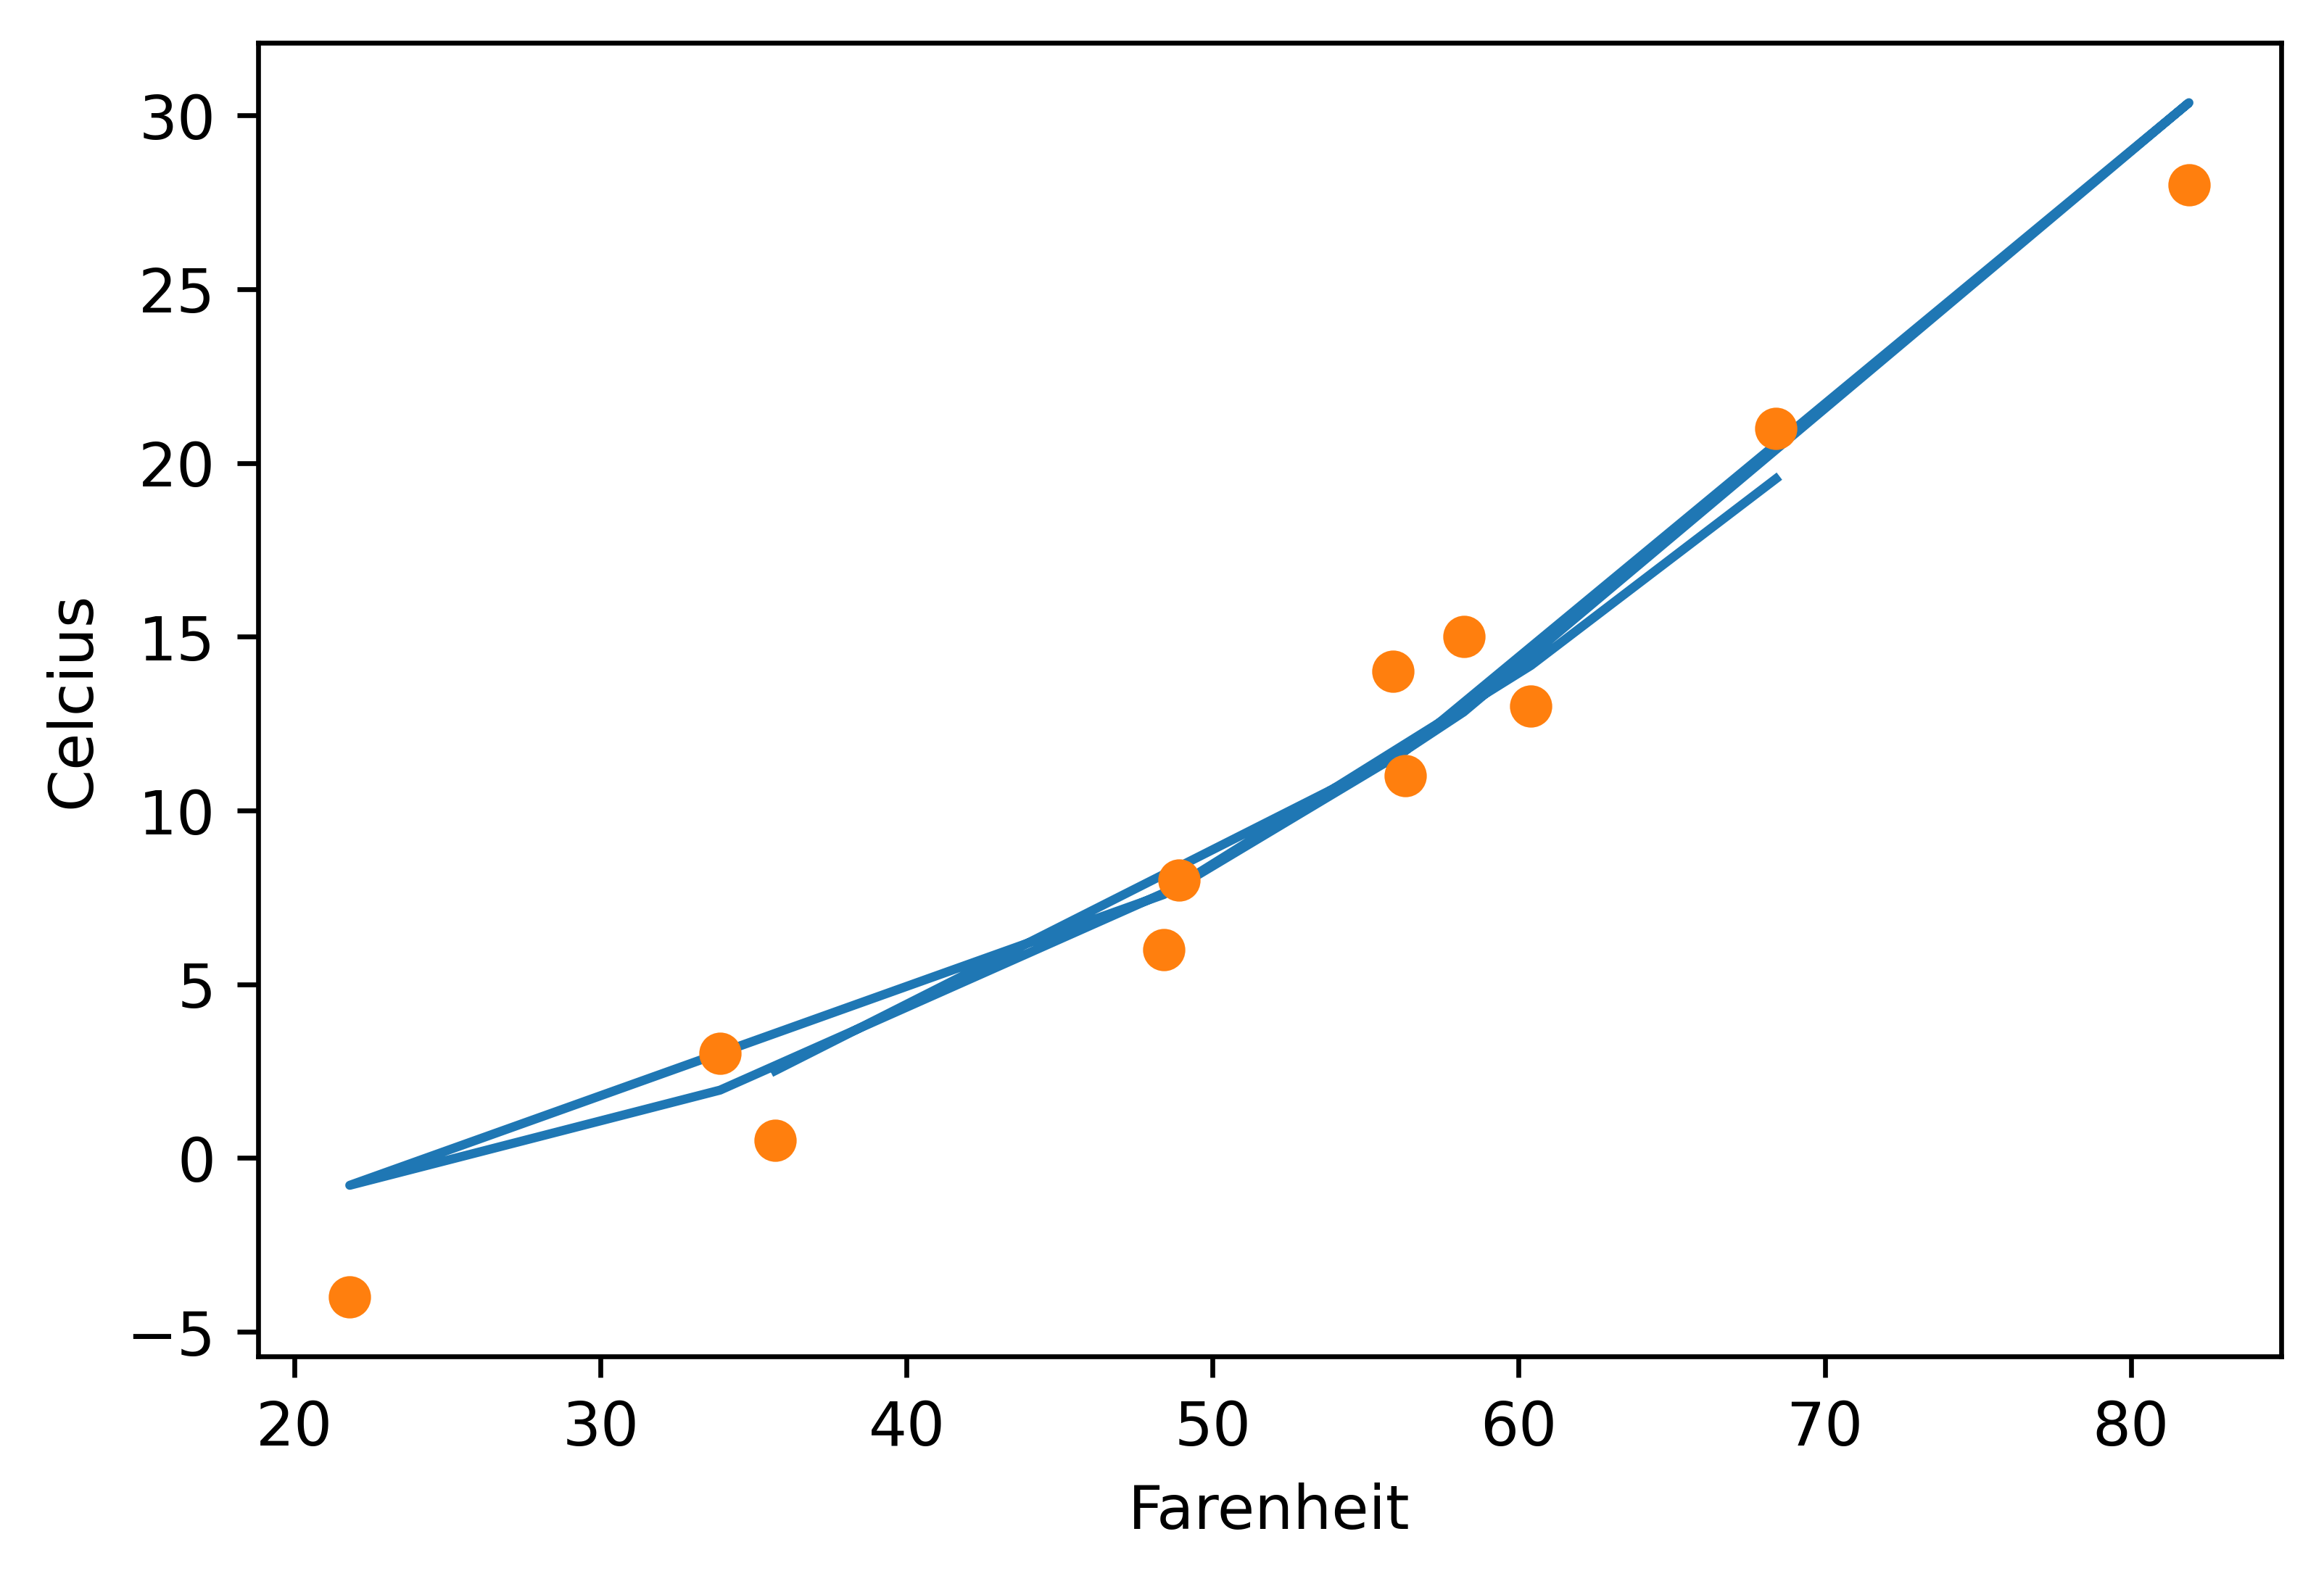

In [165]:
#change model: w2 * t_u ** 2 + w1 * t_u + b

def model_2(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

#training the same except to call model_2()
def training_loop_5(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1 + n_epochs):
        train_loss = loss_fn(model_2(train_t_u, *params), train_t_c)
        val_loss = loss_fn(model_2(val_t_u, *params), val_t_c)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

#initial params change
params = torch.tensor([1.0,1.0,0.0], requires_grad = True)

params = training_loop_5(n_epochs = 10000,
               optimizer = optim.SGD([params], lr = 1e-4),
               params = params,
               train_t_u = train_t_un,
               train_t_c = train_t_c,
               val_t_u = val_t_un,
               val_t_c = val_t_c)

t_p = model_2(t_un, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Farenheit")
plt.ylabel("Celcius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')